In [34]:
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.layers.core import Dense,Activation,Dropout
import warnings
warnings.filterwarnings("ignore")

In [36]:
data = pd.read_csv('train.csv')
data.columns

Index(['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32',
       'diagnosis'],
      dtype='object')

In [37]:
data = data.drop(['Unnamed: 32','id'], axis = 1)
data.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,11.80,16.58,78.99,432.0,0.10910,0.17000,0.16590,0.07415,0.2678,0.07371,...,26.38,91.93,591.7,0.1385,0.4092,0.45040,0.18650,0.5774,0.10300,M
1,10.26,14.71,66.20,321.6,0.09882,0.09159,0.03581,0.02037,0.1633,0.07005,...,19.48,70.89,357.1,0.1360,0.1636,0.07162,0.04074,0.2434,0.08488,B
2,15.30,25.27,102.40,732.4,0.10820,0.16970,0.16830,0.08751,0.1926,0.06540,...,36.71,149.30,1269.0,0.1641,0.6110,0.63350,0.20240,0.4027,0.09876,M
3,12.47,17.31,80.45,480.1,0.08928,0.07630,0.03609,0.02369,0.1526,0.06046,...,24.34,92.82,607.3,0.1276,0.2506,0.20280,0.10530,0.3035,0.07661,B
4,15.32,17.27,103.20,713.3,0.13350,0.22840,0.24480,0.12420,0.2398,0.07596,...,22.66,119.80,928.8,0.1765,0.4503,0.44290,0.22290,0.3258,0.11910,M


In [38]:
for col in data.columns:
    if data[col].dtypes == 'object':
        le = preprocessing.LabelEncoder()
        data[col] = le.fit_transform(data[col])
    else:
        scaler = preprocessing.StandardScaler()
        data[col] = scaler.fit_transform(np.array(data[col]).reshape(-1, 1))

<AxesSubplot:>

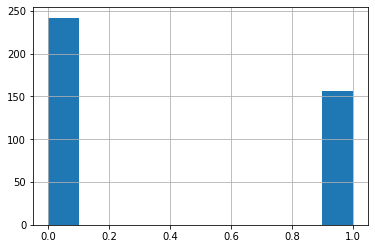

In [39]:
data['diagnosis'].hist()

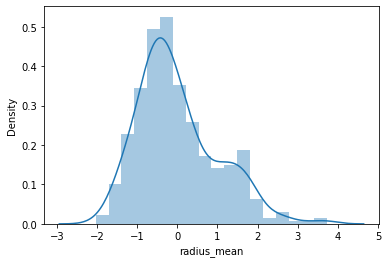

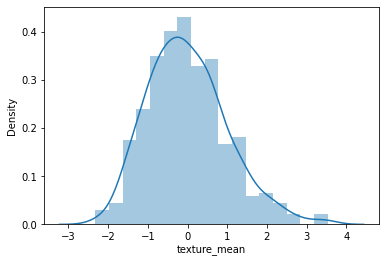

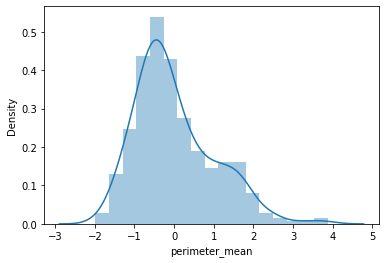

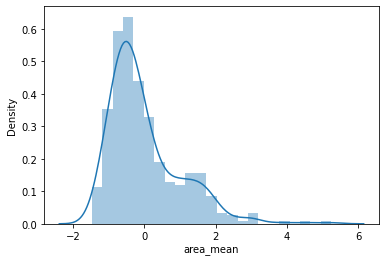

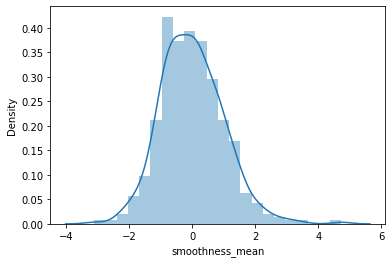

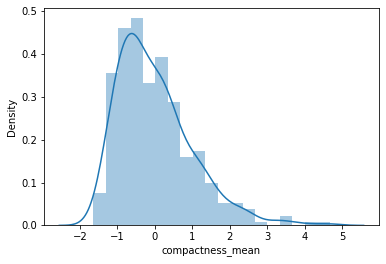

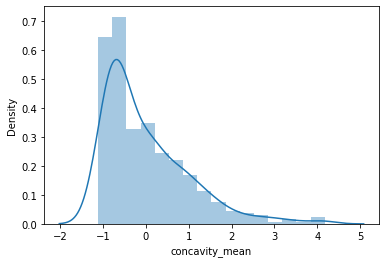

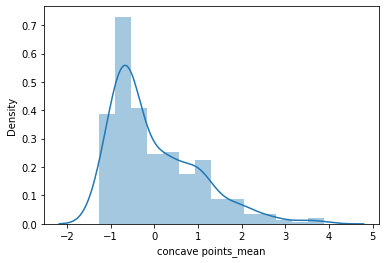

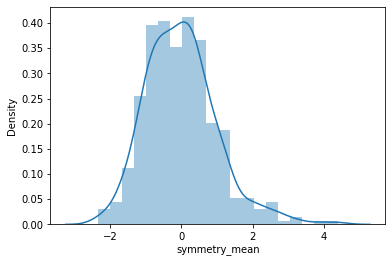

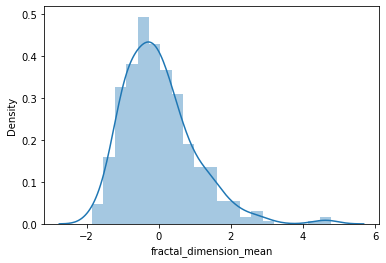

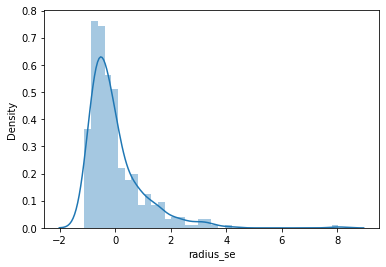

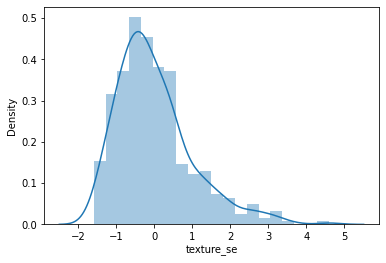

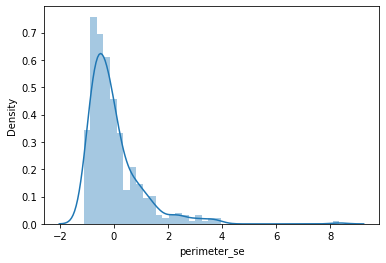

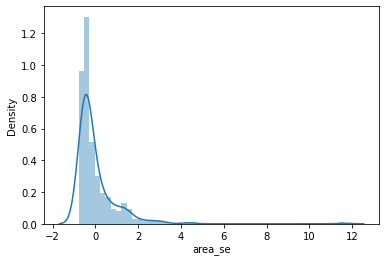

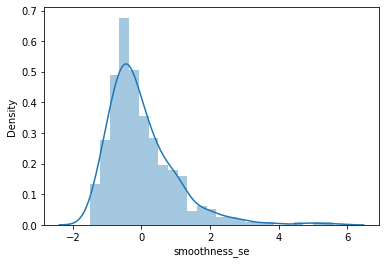

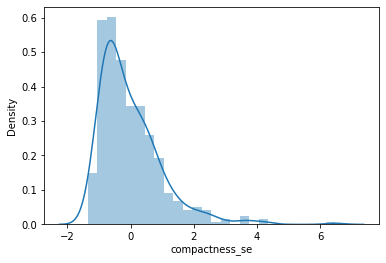

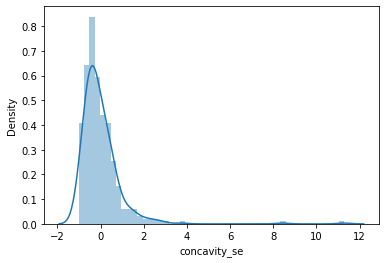

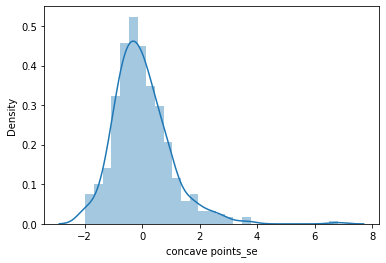

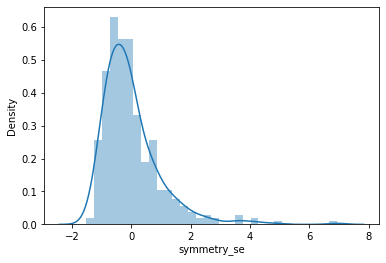

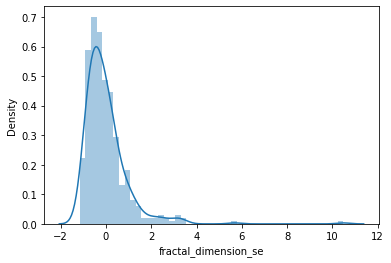

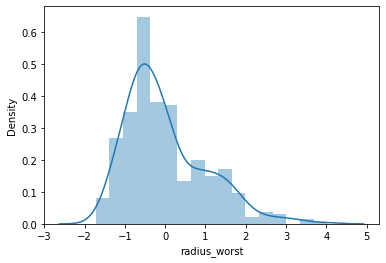

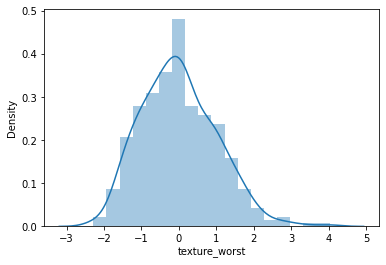

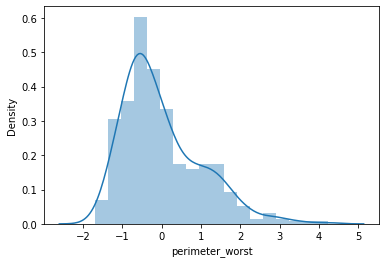

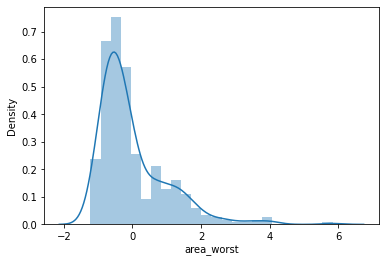

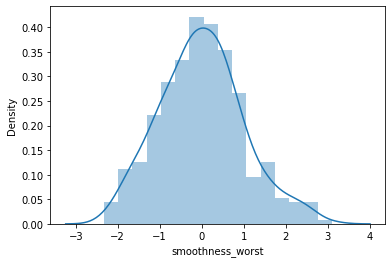

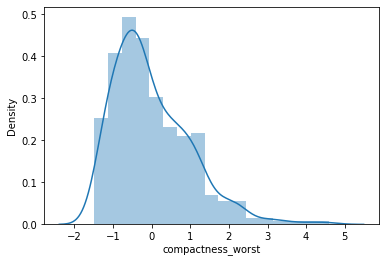

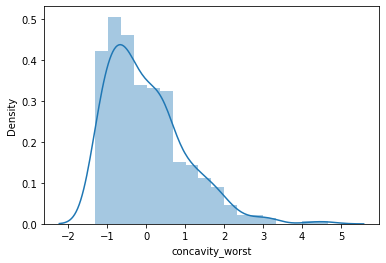

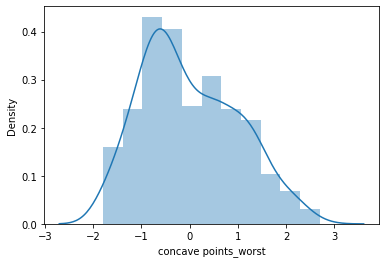

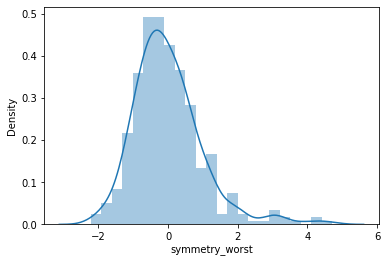

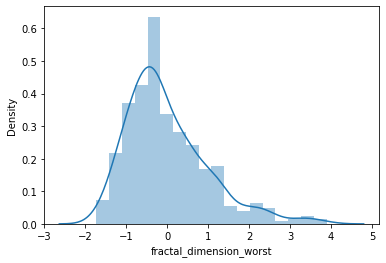

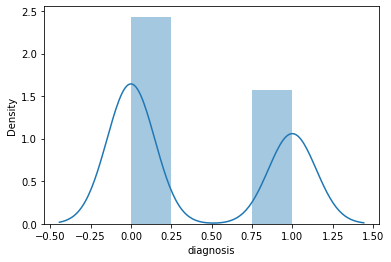

In [40]:
for column in data.columns:
    plt.figure()
    sns.distplot(data[column])

In [41]:
data.shape

(398, 31)

In [42]:
X, y = np.array(data[data.columns[:-1]]), np.array(data[data.columns[-1]])

In [43]:
def metric_values(tn, fp, fn, tp):
    result = []
    result.append(tn)
    result.append(fp)
    result.append(fn)
    result.append(tp)
    tpr = tp/(tp+fn)
    result.append(tpr)
    tnr = tn/(tn+fp)
    result.append(tnr)
    fpr = fp/(tn+fp)
    result.append(fpr)
    fnr = fn/(tp+fn)
    result.append(fnr)
    recall = tp/(tp+fn)
    result.append(recall)
    precision = tp/(tp+fp)
    result.append(precision)
    f1 = (2*tp)/(2*tp+fp+fn)
    result.append(f1)
    acc = (tp+tn)/(tp+fp+fn+tn)
    result.append(acc)
    err = (fp+fn)/(tp+fp+fn+tn)
    result.append(err)
    bacc = (tpr+tnr)/2
    result.append(bacc)
    tss = tp/(tp+fn) - fp/(fp+tn)
    result.append(tss)
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    result.append(hss)
    return np.array(result)

In [ ]:
kf = KFold(n_splits=10,shuffle=True, random_state=123)
fold = 0
lstm_mean = np.zeros(12)
rf_mean = np.zeros(12)
gnb_mean = np.zeros(12)
for train_index, test_index in kf.split(X, y):
    results = pd.DataFrame(columns=['Model','TN','FP','FN','TP','TPR','TNR','FPR','FNR','recall','precision','F1','accuracy','ER','BA','TSS','HSS'])
    fold += 1
    print("Fold", str(fold))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Random Forrest
    rf = RandomForestClassifier(max_depth=5, random_state=0)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
    rf_result = metric_values(tn, fp, fn, tp)
    ##rf_mean += rf_result
    #Naive Bayes
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred_gnb = gnb.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_gnb).ravel()
    gnb_result = metric_values(tn, fp, fn, tp)
    ##gnb_mean += gnb_result
      ##lstm
    #print (X[:5])
    #print (y[:5],set(y))
    #print (y[:5],set(y))
    
    
    X_bar = X.copy()
    y_bar = np.array([1 if k == 'B' else 0 for k in list(y)])
    
    X_train_fold = np.array(X_bar[train_index])
    y_train_fold = np.array(y_bar[train_index]).reshape(-1,1).astype(int)
    X_val_fold = np.array(X_bar[test_index])
    y_val_fold = np.array(y_bar[test_index]).reshape(-1,1).astype(int)
    
    X_train_fold = np.reshape(X_train_fold,(X_train_fold.shape[0], 1, X_train_fold.shape[1])).astype(int)
    X_val_fold = np.reshape(X_val_fold, (X_val_fold.shape[0], 1, X_val_fold.shape[1])).astype(int)
    

    model = Sequential()
    model.add(LSTM(60, return_sequences=True, input_shape=(1,30)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('Softmax'))
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    #print(f'Fold {i + 1}')
    history = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=20, validation_data=(X_val_fold, y_val_fold),
                        verbose=1, shuffle=False)
    
    ## Report LSTM Result
    y_pred_lstm = model.predict(X_val_fold)
    y_pred_lstm = np.array([t[0][0] for t in y_pred_lstm]).ravel()
    y_val_fold = np.array(y_bar[test_index]).ravel()
    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_pred_lstm).ravel()
    lstm_result = metric_values(tn, fp, fn, tp)
    ##lstm_mean += lstm_result
    results.loc[len(results.index)] = ['RandomForest'] + list(rf_result)
    results.loc[len(results.index)] = ['SVM'] + list(gnb_result)
    results.loc[len(results.index)] = ['LSTM'] + list(lstm_result)
    print (results)
    print("\n\n")

Fold 1
Epoch 1/5
18/18 [==============================] - 8s 90ms/step - loss: 15.2492 - accuracy: 0.0000e+00 - val_loss: 15.2492 - val_accuracy: 0.0000e+00
Epoch 2/5
18/18 [==============================] - 0s 9ms/step - loss: 15.2492 - accuracy: 0.0000e+00 - val_loss: 15.2492 - val_accuracy: 0.0000e+00
Epoch 3/5
18/18 [==============================] - 0s 8ms/step - loss: 15.2492 - accuracy: 0.0000e+00 - val_loss: 15.2492 - val_accuracy: 0.0000e+00
Epoch 4/5
18/18 [==============================] - 0s 8ms/step - loss: 15.2492 - accuracy: 0.0000e+00 - val_loss: 15.2492 - val_accuracy: 0.0000e+00
Epoch 5/5
18/18 [==============================] - ETA: 0s - loss: 15.2492 - accuracy: 0.0000e+0 - 0s 10ms/step - loss: 15.2492 - accuracy: 0.0000e+00 - val_loss: 15.2492 - val_accuracy: 0.0000e+00
          Model    TN    FP   FN    TP       TPR  TNR  FPR       FNR  \
0  RandomForest  23.0   0.0  2.0  15.0  0.882353  1.0  0.0  0.117647   
1           SVM  23.0   0.0  6.0  11.0  0.647059  1.0 